In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle  # For saving and loading objects
import streamlit as st
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    confusion_matrix, roc_curve, classification_report
)
from tensorflow.keras.models import load_model
import warnings
warnings.filterwarnings("ignore")


In [24]:
# Load the dataset
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target)


Selected Features:
Index(['mean radius', 'mean perimeter', 'mean area', 'mean concavity',
       'mean concave points', 'worst radius', 'worst perimeter', 'worst area',
       'worst concavity', 'worst concave points'],
      dtype='object')


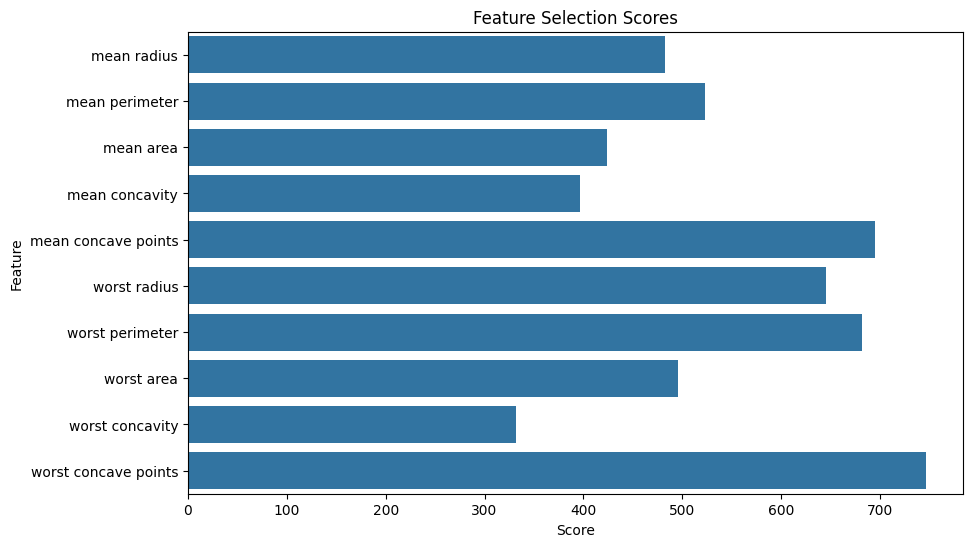

In [25]:

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Save the scaler using pickle
with open("..\model\scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

# Feature selection using SelectKBest
selector = SelectKBest(score_func=f_classif, k=10)  # Select top 10 features
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

# Save the feature selector using pickle
with open("..\model\\feature_selector.pkl", "wb") as f:
    pickle.dump(selector, f)

selected_features = X.columns[selector.get_support()]
print(f"Selected Features:\n{selected_features}")

# Visualize feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x=selector.scores_[selector.get_support()], y=selected_features)
plt.title("Feature Selection Scores")
plt.xlabel("Score")
plt.ylabel("Feature")
plt.show()

In [26]:
# Hyperparameter optimization using GridSearchCV
param_grid = {
    'hidden_layer_sizes': [(50,), (50, 30), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam'],
    'learning_rate_init': [0.001, 0.01],
    'max_iter': [200]
}

mlp = MLPClassifier(max_iter=200, random_state=42)
grid_search = GridSearchCV(mlp, param_grid, scoring='accuracy', cv=3)
grid_search.fit(X_train_selected, y_train)

best_model = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")

# Evaluate the model
y_pred = best_model.predict(X_test_selected)
y_pred_prob = best_model.predict_proba(X_test_selected)[:, 1]


Best Parameters: {'activation': 'relu', 'hidden_layer_sizes': (100, 50), 'learning_rate_init': 0.001, 'max_iter': 200, 'solver': 'adam'}


In [27]:
X_train_selected

array([[-1.44075296, -1.36208497, -1.1391179 , ..., -0.97396758,
         4.67282796,  0.9320124 ],
       [ 1.97409619,  2.09167167,  1.85197292, ...,  2.1374055 ,
         1.92862053,  2.6989469 ],
       [-1.39998202, -1.34520926, -1.10978518, ..., -0.99971493,
        -0.64491059, -0.97023893],
       ...,
       [ 0.04880192, -0.06512547, -0.06142266, ..., -0.33927781,
        -1.12796759, -1.23903365],
       [-0.03896885, -0.03137406, -0.15477966, ..., -0.01355621,
         0.63253231,  1.05001236],
       [-0.54860557, -0.60350155, -0.5518995 , ..., -0.58052694,
        -0.76538799, -0.61102866]])

Accuracy: 0.9825
Precision: 0.9859
Recall: 0.9859
F1 Score: 0.9859
ROC AUC: 0.9980


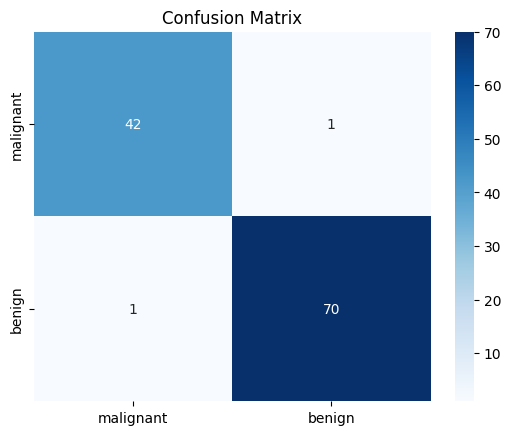

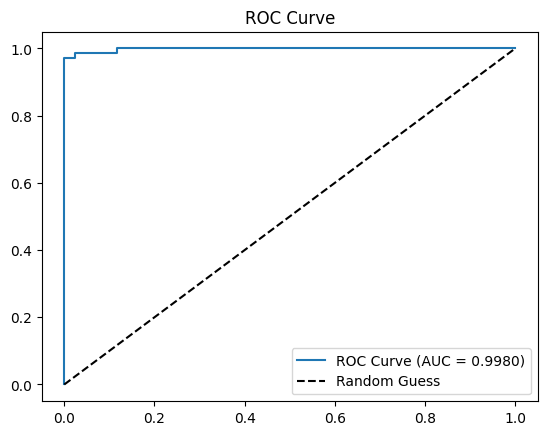

In [28]:
# Metrics and visualizations
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_prob)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=data.target_names, yticklabels=data.target_names)
plt.title('Confusion Matrix')
plt.show()

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.title('ROC Curve')
plt.legend()
plt.show()



In [29]:
# Save the ANN model
with open("..\model\\ann_model.pkl", "wb") as f:
    pickle.dump(best_model, f)